# <center>MobileNet - Pytorch

# Step 1: Prepare data

In [1]:
# MobileNet-Pytorch
import argparse 
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import accuracy_score
#from mobilenets import mobilenet

use_cuda = torch.cuda.is_available()
use_cudause_cud  = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

In [2]:
# Train, Validate, Test. Heavily inspired by Kevinzakka https://github.com/kevinzakka/DenseNet/blob/master/data_loader.py

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

valid_size=0.1

# define transforms
valid_transform = transforms.Compose([
        transforms.ToTensor(),
        normalize
])

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])


# load the dataset
train_dataset = datasets.CIFAR10(root="data", train=True, 
            download=True, transform=train_transform)

valid_dataset = datasets.CIFAR10(root="data", train=True, 
            download=True, transform=valid_transform)

num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train)) #5w张图片的10%用来当做验证集


np.random.seed(42)# 42
np.random.shuffle(indices) # 随机乱序[0,1,...,49999]

train_idx, valid_idx = indices[split:], indices[:split]


train_sampler = SubsetRandomSampler(train_idx) # 这个很有意思
valid_sampler = SubsetRandomSampler(valid_idx)

###################################################################################
# ------------------------- 使用不同的批次大小 ------------------------------------
###################################################################################

show_step=2  # 批次大，show_step就小点
max_epoch=150  # 训练最大epoch数目

train_loader = torch.utils.data.DataLoader(train_dataset, 
                batch_size=256, sampler=train_sampler)

valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                batch_size=256, sampler=valid_sampler)


test_transform = transforms.Compose([
    transforms.ToTensor(), normalize
])

test_dataset = datasets.CIFAR10(root="data", 
                                train=False, 
                                download=True,transform=test_transform)

test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=1, 
                                          shuffle=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# Step 2: Model Config

# 32  缩放5次到 1x1@1024 
# From https://github.com/kuangliu/pytorch-cifar 
import torch
import torch.nn as nn
import torch.nn.functional as F


class Block(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        
        #self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        one_conv_kernel_size = 3
        self.conv1D= nn.Conv1d(1, out_planes, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1,bias=False) # 在__init__初始化        
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        
        out = F.relu(self.bn1(self.conv1(x)))
        
        # -------------------------- Attention -----------------------
        w = F.avg_pool2d(x,x.shape[-1])  #最好在初始化层定义好
        #print(w.shape)
        # [bs,in_Channel,1,1]
        w = w.view(w.shape[0],1,w.shape[1])
        # [bs,1,in_Channel]
        # one_conv_filter = nn.Conv1d(1, out_channel, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1) # 在__init__初始化
        # [bs,out_channel,in_Channel]
        w = self.conv1D(w)
        w = 0.5*F.tanh(w) # [-0.5,+0.5]
        # -------------- softmax ---------------------------
        #print(w.shape)
        w = w.view(w.shape[0],w.shape[1],w.shape[2],1,1)
        #print(w.shape)
        
        # ------------------------- fusion --------------------------
        out=out.view(out.shape[0],1,out.shape[1],out.shape[2],out.shape[3])
        #print("x size:",out.shape)
        
        out=out*w
        #print("after fusion x size:",out.shape)
        out=out.sum(dim=2)
        
        out = F.relu(self.bn2(out))
        
        return out


class MobileNet(nn.Module):
    # (128,2) means conv planes=128, conv stride=2, by default conv stride=1
    cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), 1024]

    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32) # 自动化构建层
        self.linear = nn.Linear(1024, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for x in self.cfg:
            out_planes = x if isinstance(x, int) else x[0]
            stride = 1 if isinstance(x, int) else x[1]
            layers.append(Block(in_planes, out_planes, stride))
            in_planes = out_planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.avg_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [3]:
# 32  缩放5次到 1x1@1024 
# From https://github.com/kuangliu/pytorch-cifar 
import torch
import torch.nn as nn
import torch.nn.functional as F


     


class Block(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        return out


class MobileNet(nn.Module):
    # (128,2) means conv planes=128, conv stride=2, by default conv stride=1
    # cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), 1024]
    # cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), (1024,1)]
    cfg = [48, (96,2), 96, (192,2), 192, (384,2), 384, 384, 384, 384, 384, (768,2), (1024,1)]
    
    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32) # 自动化构建层
        self.linear = nn.Linear(1024, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for x in self.cfg:
            if isinstance(x, int):
                out_planes = x
                stride = 1 
                layers.append(Block(in_planes, out_planes, stride))
            elif isinstance(x, tuple):
                out_planes = x[0]
                stride = x[1]
                layers.append(Block(in_planes, out_planes, stride))
            # AC层通过list存放设置参数
            elif isinstance(x, list):
                out_planes= x[0]
                stride = x[1] if len(x)==2 else 1
                layers.append(Block_Attention(in_planes, out_planes, stride))   
            else:
                pass
            
            in_planes = out_planes
            
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.avg_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [4]:
# From https://github.com/Z0m6ie/CIFAR-10_PyTorch
#model = mobilenet(num_classes=10, large_img=False)

# From https://github.com/kuangliu/pytorch-cifar 
if torch.cuda.is_available():
    model=MobileNet(10).cuda()
else:
    model=MobileNet(10)

optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = StepLR(optimizer, step_size=20, gamma=0.5)
criterion = nn.CrossEntropyLoss()

In [5]:
# Implement validation
def train(epoch):
    model.train()
    #writer = SummaryWriter()
    for batch_idx, (data, target) in enumerate(train_loader):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        correct = 0
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).sum()
        
        loss = criterion(output, target)
        loss.backward()
        accuracy = 100. * (correct.cpu().numpy()/ len(output))
        optimizer.step()
        if batch_idx % 5*show_step == 0:
#             if batch_idx % 2*show_step == 0:
#                 print(model.layers[1].conv1D.weight.shape)
#                 print(model.layers[1].conv1D.weight[0:2][0:2])
            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.2f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), accuracy))
            f1=open("Cifar10_INFO.txt","a+")
            f1.write("\n"+'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.2f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), accuracy))
            f1.close()
            
            #writer.add_scalar('Loss/Loss', loss.item(), epoch)
            #writer.add_scalar('Accuracy/Accuracy', accuracy, epoch)
    scheduler.step()

In [6]:
def validate(epoch):
    model.eval()
    #writer = SummaryWriter()
    valid_loss = 0
    correct = 0
    for data, target in valid_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        valid_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).sum()

    valid_loss /= len(valid_idx)
    accuracy = 100. * correct.cpu().numpy() / len(valid_idx)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        valid_loss, correct, len(valid_idx),
        100. * correct / len(valid_idx)))
    
    f1=open("Cifar10_INFO.txt","a+")
    f1.write('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        valid_loss, correct, len(valid_idx),
        100. * correct / len(valid_idx)))
    f1.close()
    #writer.add_scalar('Loss/Validation_Loss', valid_loss, epoch)
    #writer.add_scalar('Accuracy/Validation_Accuracy', accuracy, epoch)
    return valid_loss, accuracy

In [7]:
# Fix best model

def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct.cpu().numpy() / len(test_loader.dataset)))
    
    f1=open("Cifar10_INFO.txt","a+")
    f1.write('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct.cpu().numpy() / len(test_loader.dataset)))
    f1.close()

In [8]:
def save_best(loss, accuracy, best_loss, best_acc):
    if best_loss == None:
        best_loss = loss
        best_acc = accuracy
        file = 'saved_models/best_save_model.p'
        torch.save(model.state_dict(), file)
        
    elif loss < best_loss and accuracy > best_acc:
        best_loss = loss
        best_acc = accuracy
        file = 'saved_models/best_save_model.p'
        torch.save(model.state_dict(), file)
    return best_loss, best_acc

In [9]:
# Fantastic logger for tensorboard and pytorch, 
# run tensorboard by opening a new terminal and run "tensorboard --logdir runs"
# open tensorboard at http://localhost:6006/
from tensorboardX import SummaryWriter
best_loss = None
best_acc = None

import time 
SINCE=time.time()

for epoch in range(max_epoch):
    train(epoch)
    
    loss, accuracy = validate(epoch)
    best_loss, best_acc = save_best(loss, accuracy, best_loss, best_acc)
    
    NOW=time.time() 
    DURINGS=NOW-SINCE
    SINCE=NOW
    print("the time of this epoch:[{} s]".format(DURINGS))
    
# writer = SummaryWriter() 
# writer.export_scalars_to_json("./all_scalars.json")

# writer.close()

#---------------------------- Test ------------------------------
test(epoch)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.315224, Accuracy: 9.38
Train Epoch: 0 [1280/50000 (3%)]	Loss: 2.287147, Accuracy: 13.28
Train Epoch: 0 [2560/50000 (6%)]	Loss: 2.368712, Accuracy: 19.92
Train Epoch: 0 [3840/50000 (9%)]	Loss: 2.068045, Accuracy: 21.09
Train Epoch: 0 [5120/50000 (11%)]	Loss: 2.055146, Accuracy: 19.92
Train Epoch: 0 [6400/50000 (14%)]	Loss: 2.023268, Accuracy: 24.61
Train Epoch: 0 [7680/50000 (17%)]	Loss: 2.099804, Accuracy: 19.14
Train Epoch: 0 [8960/50000 (20%)]	Loss: 1.988075, Accuracy: 28.12
Train Epoch: 0 [10240/50000 (23%)]	Loss: 1.940798, Accuracy: 27.34
Train Epoch: 0 [11520/50000 (26%)]	Loss: 1.966440, Accuracy: 24.22
Train Epoch: 0 [12800/50000 (28%)]	Loss: 1.820027, Accuracy: 29.69
Train Epoch: 0 [14080/50000 (31%)]	Loss: 1.962844, Accuracy: 24.61
Train Epoch: 0 [15360/50000 (34%)]	Loss: 1.865177, Accuracy: 29.30
Train Epoch: 0 [16640/50000 (37%)]	Loss: 1.868417, Accuracy: 25.78
Train Epoch: 0 [17920/50000 (40%)]	Loss: 1.878238, Accuracy: 28.91
Train Epoch

Train Epoch: 3 [14080/50000 (31%)]	Loss: 1.059494, Accuracy: 66.41
Train Epoch: 3 [15360/50000 (34%)]	Loss: 1.028736, Accuracy: 63.67
Train Epoch: 3 [16640/50000 (37%)]	Loss: 0.999447, Accuracy: 64.06
Train Epoch: 3 [17920/50000 (40%)]	Loss: 0.979837, Accuracy: 62.11
Train Epoch: 3 [19200/50000 (43%)]	Loss: 0.900894, Accuracy: 70.70
Train Epoch: 3 [20480/50000 (45%)]	Loss: 1.103181, Accuracy: 62.89
Train Epoch: 3 [21760/50000 (48%)]	Loss: 0.938985, Accuracy: 67.19
Train Epoch: 3 [23040/50000 (51%)]	Loss: 0.915501, Accuracy: 67.19
Train Epoch: 3 [24320/50000 (54%)]	Loss: 0.926821, Accuracy: 68.75
Train Epoch: 3 [25600/50000 (57%)]	Loss: 1.070376, Accuracy: 64.84
Train Epoch: 3 [26880/50000 (60%)]	Loss: 0.981347, Accuracy: 63.67
Train Epoch: 3 [28160/50000 (62%)]	Loss: 1.044278, Accuracy: 62.50
Train Epoch: 3 [29440/50000 (65%)]	Loss: 0.833426, Accuracy: 71.88
Train Epoch: 3 [30720/50000 (68%)]	Loss: 0.885050, Accuracy: 67.58
Train Epoch: 3 [32000/50000 (71%)]	Loss: 0.864293, Accuracy: 6

Train Epoch: 6 [26880/50000 (60%)]	Loss: 0.660979, Accuracy: 75.78
Train Epoch: 6 [28160/50000 (62%)]	Loss: 0.566852, Accuracy: 79.30
Train Epoch: 6 [29440/50000 (65%)]	Loss: 0.680295, Accuracy: 73.83
Train Epoch: 6 [30720/50000 (68%)]	Loss: 0.694098, Accuracy: 74.22
Train Epoch: 6 [32000/50000 (71%)]	Loss: 0.608462, Accuracy: 79.30
Train Epoch: 6 [33280/50000 (74%)]	Loss: 0.697147, Accuracy: 75.39
Train Epoch: 6 [34560/50000 (77%)]	Loss: 0.696813, Accuracy: 76.95
Train Epoch: 6 [35840/50000 (80%)]	Loss: 0.621173, Accuracy: 75.39
Train Epoch: 6 [37120/50000 (82%)]	Loss: 0.573990, Accuracy: 80.47
Train Epoch: 6 [38400/50000 (85%)]	Loss: 0.697988, Accuracy: 75.00
Train Epoch: 6 [39680/50000 (88%)]	Loss: 0.606138, Accuracy: 77.73
Train Epoch: 6 [40960/50000 (91%)]	Loss: 0.602004, Accuracy: 79.69
Train Epoch: 6 [42240/50000 (94%)]	Loss: 0.597861, Accuracy: 78.52
Train Epoch: 6 [43520/50000 (97%)]	Loss: 0.793198, Accuracy: 70.31
Train Epoch: 6 [35000/50000 (99%)]	Loss: 0.654849, Accuracy: 7

Train Epoch: 9 [39680/50000 (88%)]	Loss: 0.463392, Accuracy: 83.59
Train Epoch: 9 [40960/50000 (91%)]	Loss: 0.751901, Accuracy: 76.17
Train Epoch: 9 [42240/50000 (94%)]	Loss: 0.509760, Accuracy: 80.47
Train Epoch: 9 [43520/50000 (97%)]	Loss: 0.604976, Accuracy: 77.34
Train Epoch: 9 [35000/50000 (99%)]	Loss: 0.540504, Accuracy: 83.00

Validation set: Average loss: 0.6315, Accuracy: 3934/5000 (78.00%)

the time of this epoch:[18.96917748451233 s]
Train Epoch: 10 [0/50000 (0%)]	Loss: 0.464038, Accuracy: 84.77
Train Epoch: 10 [1280/50000 (3%)]	Loss: 0.596877, Accuracy: 77.34
Train Epoch: 10 [2560/50000 (6%)]	Loss: 0.516289, Accuracy: 81.25
Train Epoch: 10 [3840/50000 (9%)]	Loss: 0.507985, Accuracy: 83.98
Train Epoch: 10 [5120/50000 (11%)]	Loss: 0.554808, Accuracy: 83.20
Train Epoch: 10 [6400/50000 (14%)]	Loss: 0.517801, Accuracy: 79.69
Train Epoch: 10 [7680/50000 (17%)]	Loss: 0.606017, Accuracy: 78.52
Train Epoch: 10 [8960/50000 (20%)]	Loss: 0.551426, Accuracy: 81.25
Train Epoch: 10 [10240

Train Epoch: 13 [2560/50000 (6%)]	Loss: 0.440248, Accuracy: 85.94
Train Epoch: 13 [3840/50000 (9%)]	Loss: 0.461099, Accuracy: 82.03
Train Epoch: 13 [5120/50000 (11%)]	Loss: 0.491346, Accuracy: 80.47
Train Epoch: 13 [6400/50000 (14%)]	Loss: 0.417675, Accuracy: 84.38
Train Epoch: 13 [7680/50000 (17%)]	Loss: 0.538546, Accuracy: 82.03
Train Epoch: 13 [8960/50000 (20%)]	Loss: 0.507052, Accuracy: 80.47
Train Epoch: 13 [10240/50000 (23%)]	Loss: 0.542584, Accuracy: 80.47
Train Epoch: 13 [11520/50000 (26%)]	Loss: 0.431102, Accuracy: 86.33
Train Epoch: 13 [12800/50000 (28%)]	Loss: 0.458057, Accuracy: 83.98
Train Epoch: 13 [14080/50000 (31%)]	Loss: 0.435106, Accuracy: 85.55
Train Epoch: 13 [15360/50000 (34%)]	Loss: 0.549813, Accuracy: 81.25
Train Epoch: 13 [16640/50000 (37%)]	Loss: 0.507309, Accuracy: 80.86
Train Epoch: 13 [17920/50000 (40%)]	Loss: 0.560329, Accuracy: 79.30
Train Epoch: 13 [19200/50000 (43%)]	Loss: 0.499967, Accuracy: 84.38
Train Epoch: 13 [20480/50000 (45%)]	Loss: 0.460317, Accu

Train Epoch: 16 [14080/50000 (31%)]	Loss: 0.427851, Accuracy: 83.59
Train Epoch: 16 [15360/50000 (34%)]	Loss: 0.374607, Accuracy: 87.11
Train Epoch: 16 [16640/50000 (37%)]	Loss: 0.388984, Accuracy: 85.55
Train Epoch: 16 [17920/50000 (40%)]	Loss: 0.594472, Accuracy: 80.86
Train Epoch: 16 [19200/50000 (43%)]	Loss: 0.412682, Accuracy: 85.55
Train Epoch: 16 [20480/50000 (45%)]	Loss: 0.481200, Accuracy: 85.16
Train Epoch: 16 [21760/50000 (48%)]	Loss: 0.516083, Accuracy: 83.59
Train Epoch: 16 [23040/50000 (51%)]	Loss: 0.467547, Accuracy: 83.59
Train Epoch: 16 [24320/50000 (54%)]	Loss: 0.374342, Accuracy: 85.55
Train Epoch: 16 [25600/50000 (57%)]	Loss: 0.342192, Accuracy: 87.50
Train Epoch: 16 [26880/50000 (60%)]	Loss: 0.421356, Accuracy: 85.94
Train Epoch: 16 [28160/50000 (62%)]	Loss: 0.544647, Accuracy: 80.08
Train Epoch: 16 [29440/50000 (65%)]	Loss: 0.463505, Accuracy: 83.59
Train Epoch: 16 [30720/50000 (68%)]	Loss: 0.426843, Accuracy: 83.98
Train Epoch: 16 [32000/50000 (71%)]	Loss: 0.4677

Train Epoch: 19 [25600/50000 (57%)]	Loss: 0.334200, Accuracy: 88.67
Train Epoch: 19 [26880/50000 (60%)]	Loss: 0.452975, Accuracy: 83.20
Train Epoch: 19 [28160/50000 (62%)]	Loss: 0.384594, Accuracy: 87.50
Train Epoch: 19 [29440/50000 (65%)]	Loss: 0.462677, Accuracy: 85.94
Train Epoch: 19 [30720/50000 (68%)]	Loss: 0.316688, Accuracy: 89.45
Train Epoch: 19 [32000/50000 (71%)]	Loss: 0.318236, Accuracy: 87.50
Train Epoch: 19 [33280/50000 (74%)]	Loss: 0.417772, Accuracy: 86.33
Train Epoch: 19 [34560/50000 (77%)]	Loss: 0.407620, Accuracy: 85.55
Train Epoch: 19 [35840/50000 (80%)]	Loss: 0.428564, Accuracy: 82.42
Train Epoch: 19 [37120/50000 (82%)]	Loss: 0.387191, Accuracy: 89.06
Train Epoch: 19 [38400/50000 (85%)]	Loss: 0.426614, Accuracy: 83.98
Train Epoch: 19 [39680/50000 (88%)]	Loss: 0.441189, Accuracy: 85.94
Train Epoch: 19 [40960/50000 (91%)]	Loss: 0.306082, Accuracy: 90.23
Train Epoch: 19 [42240/50000 (94%)]	Loss: 0.384716, Accuracy: 87.50
Train Epoch: 19 [43520/50000 (97%)]	Loss: 0.3901

Train Epoch: 22 [37120/50000 (82%)]	Loss: 0.350855, Accuracy: 88.28
Train Epoch: 22 [38400/50000 (85%)]	Loss: 0.258805, Accuracy: 92.97
Train Epoch: 22 [39680/50000 (88%)]	Loss: 0.351217, Accuracy: 87.50
Train Epoch: 22 [40960/50000 (91%)]	Loss: 0.314528, Accuracy: 89.06
Train Epoch: 22 [42240/50000 (94%)]	Loss: 0.396316, Accuracy: 85.16
Train Epoch: 22 [43520/50000 (97%)]	Loss: 0.291675, Accuracy: 91.41
Train Epoch: 22 [35000/50000 (99%)]	Loss: 0.248029, Accuracy: 91.00

Validation set: Average loss: 0.4086, Accuracy: 4318/5000 (86.00%)

the time of this epoch:[18.728049755096436 s]
Train Epoch: 23 [0/50000 (0%)]	Loss: 0.247735, Accuracy: 89.84
Train Epoch: 23 [1280/50000 (3%)]	Loss: 0.252277, Accuracy: 92.58
Train Epoch: 23 [2560/50000 (6%)]	Loss: 0.267996, Accuracy: 90.62
Train Epoch: 23 [3840/50000 (9%)]	Loss: 0.261187, Accuracy: 90.62
Train Epoch: 23 [5120/50000 (11%)]	Loss: 0.279810, Accuracy: 91.80
Train Epoch: 23 [6400/50000 (14%)]	Loss: 0.289629, Accuracy: 90.23
Train Epoch: 2

Train Epoch: 26 [1280/50000 (3%)]	Loss: 0.254710, Accuracy: 89.06
Train Epoch: 26 [2560/50000 (6%)]	Loss: 0.274710, Accuracy: 92.58
Train Epoch: 26 [3840/50000 (9%)]	Loss: 0.257993, Accuracy: 91.41
Train Epoch: 26 [5120/50000 (11%)]	Loss: 0.219970, Accuracy: 92.97
Train Epoch: 26 [6400/50000 (14%)]	Loss: 0.247883, Accuracy: 90.23
Train Epoch: 26 [7680/50000 (17%)]	Loss: 0.210888, Accuracy: 92.19
Train Epoch: 26 [8960/50000 (20%)]	Loss: 0.224795, Accuracy: 91.02
Train Epoch: 26 [10240/50000 (23%)]	Loss: 0.307616, Accuracy: 88.67
Train Epoch: 26 [11520/50000 (26%)]	Loss: 0.303408, Accuracy: 89.06
Train Epoch: 26 [12800/50000 (28%)]	Loss: 0.235310, Accuracy: 92.58
Train Epoch: 26 [14080/50000 (31%)]	Loss: 0.311533, Accuracy: 90.62
Train Epoch: 26 [15360/50000 (34%)]	Loss: 0.282696, Accuracy: 89.84
Train Epoch: 26 [16640/50000 (37%)]	Loss: 0.297037, Accuracy: 89.84
Train Epoch: 26 [17920/50000 (40%)]	Loss: 0.280339, Accuracy: 89.45
Train Epoch: 26 [19200/50000 (43%)]	Loss: 0.291950, Accura

Train Epoch: 29 [12800/50000 (28%)]	Loss: 0.256813, Accuracy: 91.80
Train Epoch: 29 [14080/50000 (31%)]	Loss: 0.312327, Accuracy: 88.28
Train Epoch: 29 [15360/50000 (34%)]	Loss: 0.337522, Accuracy: 87.11
Train Epoch: 29 [16640/50000 (37%)]	Loss: 0.264094, Accuracy: 87.50
Train Epoch: 29 [17920/50000 (40%)]	Loss: 0.269055, Accuracy: 90.23
Train Epoch: 29 [19200/50000 (43%)]	Loss: 0.161860, Accuracy: 93.75
Train Epoch: 29 [20480/50000 (45%)]	Loss: 0.242407, Accuracy: 89.84
Train Epoch: 29 [21760/50000 (48%)]	Loss: 0.244567, Accuracy: 91.80
Train Epoch: 29 [23040/50000 (51%)]	Loss: 0.297271, Accuracy: 89.84
Train Epoch: 29 [24320/50000 (54%)]	Loss: 0.237872, Accuracy: 91.80
Train Epoch: 29 [25600/50000 (57%)]	Loss: 0.238465, Accuracy: 91.80
Train Epoch: 29 [26880/50000 (60%)]	Loss: 0.314046, Accuracy: 87.89
Train Epoch: 29 [28160/50000 (62%)]	Loss: 0.227961, Accuracy: 92.19
Train Epoch: 29 [29440/50000 (65%)]	Loss: 0.272023, Accuracy: 90.62
Train Epoch: 29 [30720/50000 (68%)]	Loss: 0.2544

Train Epoch: 32 [24320/50000 (54%)]	Loss: 0.252578, Accuracy: 90.62
Train Epoch: 32 [25600/50000 (57%)]	Loss: 0.323301, Accuracy: 89.06
Train Epoch: 32 [26880/50000 (60%)]	Loss: 0.190790, Accuracy: 91.80
Train Epoch: 32 [28160/50000 (62%)]	Loss: 0.259218, Accuracy: 90.62
Train Epoch: 32 [29440/50000 (65%)]	Loss: 0.271339, Accuracy: 91.41
Train Epoch: 32 [30720/50000 (68%)]	Loss: 0.305090, Accuracy: 89.84
Train Epoch: 32 [32000/50000 (71%)]	Loss: 0.285262, Accuracy: 88.67
Train Epoch: 32 [33280/50000 (74%)]	Loss: 0.190421, Accuracy: 94.14
Train Epoch: 32 [34560/50000 (77%)]	Loss: 0.289421, Accuracy: 87.89
Train Epoch: 32 [35840/50000 (80%)]	Loss: 0.241912, Accuracy: 91.80
Train Epoch: 32 [37120/50000 (82%)]	Loss: 0.235292, Accuracy: 89.84
Train Epoch: 32 [38400/50000 (85%)]	Loss: 0.222527, Accuracy: 91.41
Train Epoch: 32 [39680/50000 (88%)]	Loss: 0.248238, Accuracy: 91.80
Train Epoch: 32 [40960/50000 (91%)]	Loss: 0.266460, Accuracy: 89.06
Train Epoch: 32 [42240/50000 (94%)]	Loss: 0.3782

Train Epoch: 35 [35840/50000 (80%)]	Loss: 0.239371, Accuracy: 92.97
Train Epoch: 35 [37120/50000 (82%)]	Loss: 0.177352, Accuracy: 94.14
Train Epoch: 35 [38400/50000 (85%)]	Loss: 0.279263, Accuracy: 89.45
Train Epoch: 35 [39680/50000 (88%)]	Loss: 0.279173, Accuracy: 90.62
Train Epoch: 35 [40960/50000 (91%)]	Loss: 0.153976, Accuracy: 92.19
Train Epoch: 35 [42240/50000 (94%)]	Loss: 0.197012, Accuracy: 90.62
Train Epoch: 35 [43520/50000 (97%)]	Loss: 0.324865, Accuracy: 87.11
Train Epoch: 35 [35000/50000 (99%)]	Loss: 0.248822, Accuracy: 92.50

Validation set: Average loss: 0.3961, Accuracy: 4356/5000 (87.00%)

the time of this epoch:[18.522472143173218 s]
Train Epoch: 36 [0/50000 (0%)]	Loss: 0.284679, Accuracy: 89.45
Train Epoch: 36 [1280/50000 (3%)]	Loss: 0.136066, Accuracy: 95.31
Train Epoch: 36 [2560/50000 (6%)]	Loss: 0.251329, Accuracy: 92.58
Train Epoch: 36 [3840/50000 (9%)]	Loss: 0.214512, Accuracy: 93.36
Train Epoch: 36 [5120/50000 (11%)]	Loss: 0.167230, Accuracy: 94.53
Train Epoch: 

Train Epoch: 39 [1280/50000 (3%)]	Loss: 0.172074, Accuracy: 93.36
Train Epoch: 39 [2560/50000 (6%)]	Loss: 0.214374, Accuracy: 91.80
Train Epoch: 39 [3840/50000 (9%)]	Loss: 0.224365, Accuracy: 91.41
Train Epoch: 39 [5120/50000 (11%)]	Loss: 0.216359, Accuracy: 94.14
Train Epoch: 39 [6400/50000 (14%)]	Loss: 0.251442, Accuracy: 91.41
Train Epoch: 39 [7680/50000 (17%)]	Loss: 0.256061, Accuracy: 91.41
Train Epoch: 39 [8960/50000 (20%)]	Loss: 0.141005, Accuracy: 93.36
Train Epoch: 39 [10240/50000 (23%)]	Loss: 0.271648, Accuracy: 90.62
Train Epoch: 39 [11520/50000 (26%)]	Loss: 0.206411, Accuracy: 92.97
Train Epoch: 39 [12800/50000 (28%)]	Loss: 0.166869, Accuracy: 93.75
Train Epoch: 39 [14080/50000 (31%)]	Loss: 0.178901, Accuracy: 93.75
Train Epoch: 39 [15360/50000 (34%)]	Loss: 0.203924, Accuracy: 92.97
Train Epoch: 39 [16640/50000 (37%)]	Loss: 0.190243, Accuracy: 93.75
Train Epoch: 39 [17920/50000 (40%)]	Loss: 0.239649, Accuracy: 91.80
Train Epoch: 39 [19200/50000 (43%)]	Loss: 0.140703, Accura

Train Epoch: 42 [12800/50000 (28%)]	Loss: 0.140336, Accuracy: 96.09
Train Epoch: 42 [14080/50000 (31%)]	Loss: 0.118465, Accuracy: 95.31
Train Epoch: 42 [15360/50000 (34%)]	Loss: 0.119176, Accuracy: 95.70
Train Epoch: 42 [16640/50000 (37%)]	Loss: 0.135896, Accuracy: 94.92
Train Epoch: 42 [17920/50000 (40%)]	Loss: 0.162109, Accuracy: 93.75
Train Epoch: 42 [19200/50000 (43%)]	Loss: 0.165421, Accuracy: 93.36
Train Epoch: 42 [20480/50000 (45%)]	Loss: 0.157798, Accuracy: 95.31
Train Epoch: 42 [21760/50000 (48%)]	Loss: 0.225789, Accuracy: 91.80
Train Epoch: 42 [23040/50000 (51%)]	Loss: 0.133185, Accuracy: 93.75
Train Epoch: 42 [24320/50000 (54%)]	Loss: 0.174617, Accuracy: 93.75
Train Epoch: 42 [25600/50000 (57%)]	Loss: 0.109874, Accuracy: 96.09
Train Epoch: 42 [26880/50000 (60%)]	Loss: 0.111160, Accuracy: 95.31
Train Epoch: 42 [28160/50000 (62%)]	Loss: 0.086977, Accuracy: 97.27
Train Epoch: 42 [29440/50000 (65%)]	Loss: 0.107984, Accuracy: 96.09
Train Epoch: 42 [30720/50000 (68%)]	Loss: 0.1182

Train Epoch: 45 [24320/50000 (54%)]	Loss: 0.135852, Accuracy: 94.92
Train Epoch: 45 [25600/50000 (57%)]	Loss: 0.174642, Accuracy: 93.36
Train Epoch: 45 [26880/50000 (60%)]	Loss: 0.123787, Accuracy: 96.09
Train Epoch: 45 [28160/50000 (62%)]	Loss: 0.070625, Accuracy: 96.48
Train Epoch: 45 [29440/50000 (65%)]	Loss: 0.143810, Accuracy: 95.70
Train Epoch: 45 [30720/50000 (68%)]	Loss: 0.175444, Accuracy: 94.92
Train Epoch: 45 [32000/50000 (71%)]	Loss: 0.129275, Accuracy: 94.92
Train Epoch: 45 [33280/50000 (74%)]	Loss: 0.160976, Accuracy: 93.75
Train Epoch: 45 [34560/50000 (77%)]	Loss: 0.136015, Accuracy: 94.92
Train Epoch: 45 [35840/50000 (80%)]	Loss: 0.155626, Accuracy: 92.58
Train Epoch: 45 [37120/50000 (82%)]	Loss: 0.153233, Accuracy: 92.97
Train Epoch: 45 [38400/50000 (85%)]	Loss: 0.237067, Accuracy: 92.58
Train Epoch: 45 [39680/50000 (88%)]	Loss: 0.159911, Accuracy: 94.92
Train Epoch: 45 [40960/50000 (91%)]	Loss: 0.117465, Accuracy: 96.09
Train Epoch: 45 [42240/50000 (94%)]	Loss: 0.1929

Train Epoch: 48 [35840/50000 (80%)]	Loss: 0.195918, Accuracy: 94.14
Train Epoch: 48 [37120/50000 (82%)]	Loss: 0.123030, Accuracy: 95.31
Train Epoch: 48 [38400/50000 (85%)]	Loss: 0.113131, Accuracy: 95.70
Train Epoch: 48 [39680/50000 (88%)]	Loss: 0.150011, Accuracy: 93.75
Train Epoch: 48 [40960/50000 (91%)]	Loss: 0.101197, Accuracy: 96.88
Train Epoch: 48 [42240/50000 (94%)]	Loss: 0.168788, Accuracy: 94.92
Train Epoch: 48 [43520/50000 (97%)]	Loss: 0.052903, Accuracy: 98.44
Train Epoch: 48 [35000/50000 (99%)]	Loss: 0.090703, Accuracy: 97.50

Validation set: Average loss: 0.4005, Accuracy: 4402/5000 (88.00%)

the time of this epoch:[18.483590364456177 s]
Train Epoch: 49 [0/50000 (0%)]	Loss: 0.109317, Accuracy: 95.70
Train Epoch: 49 [1280/50000 (3%)]	Loss: 0.100268, Accuracy: 96.48
Train Epoch: 49 [2560/50000 (6%)]	Loss: 0.146835, Accuracy: 94.92
Train Epoch: 49 [3840/50000 (9%)]	Loss: 0.112698, Accuracy: 95.70
Train Epoch: 49 [5120/50000 (11%)]	Loss: 0.131152, Accuracy: 95.31
Train Epoch: 

Train Epoch: 52 [1280/50000 (3%)]	Loss: 0.109883, Accuracy: 95.70
Train Epoch: 52 [2560/50000 (6%)]	Loss: 0.085842, Accuracy: 97.27
Train Epoch: 52 [3840/50000 (9%)]	Loss: 0.141128, Accuracy: 95.70
Train Epoch: 52 [5120/50000 (11%)]	Loss: 0.160102, Accuracy: 94.14
Train Epoch: 52 [6400/50000 (14%)]	Loss: 0.107601, Accuracy: 96.09
Train Epoch: 52 [7680/50000 (17%)]	Loss: 0.085716, Accuracy: 95.70
Train Epoch: 52 [8960/50000 (20%)]	Loss: 0.086692, Accuracy: 96.88
Train Epoch: 52 [10240/50000 (23%)]	Loss: 0.098892, Accuracy: 96.09
Train Epoch: 52 [11520/50000 (26%)]	Loss: 0.132332, Accuracy: 95.70
Train Epoch: 52 [12800/50000 (28%)]	Loss: 0.140982, Accuracy: 94.14
Train Epoch: 52 [14080/50000 (31%)]	Loss: 0.075744, Accuracy: 96.88
Train Epoch: 52 [15360/50000 (34%)]	Loss: 0.198112, Accuracy: 94.53
Train Epoch: 52 [16640/50000 (37%)]	Loss: 0.181733, Accuracy: 92.58
Train Epoch: 52 [17920/50000 (40%)]	Loss: 0.122221, Accuracy: 96.09
Train Epoch: 52 [19200/50000 (43%)]	Loss: 0.127159, Accura

Train Epoch: 55 [12800/50000 (28%)]	Loss: 0.124153, Accuracy: 95.70
Train Epoch: 55 [14080/50000 (31%)]	Loss: 0.128110, Accuracy: 95.31
Train Epoch: 55 [15360/50000 (34%)]	Loss: 0.161489, Accuracy: 95.31
Train Epoch: 55 [16640/50000 (37%)]	Loss: 0.107856, Accuracy: 96.09
Train Epoch: 55 [17920/50000 (40%)]	Loss: 0.121632, Accuracy: 96.48
Train Epoch: 55 [19200/50000 (43%)]	Loss: 0.098061, Accuracy: 95.70
Train Epoch: 55 [20480/50000 (45%)]	Loss: 0.084110, Accuracy: 97.66
Train Epoch: 55 [21760/50000 (48%)]	Loss: 0.144329, Accuracy: 95.31
Train Epoch: 55 [23040/50000 (51%)]	Loss: 0.138225, Accuracy: 94.53
Train Epoch: 55 [24320/50000 (54%)]	Loss: 0.115735, Accuracy: 95.31
Train Epoch: 55 [25600/50000 (57%)]	Loss: 0.133311, Accuracy: 95.31
Train Epoch: 55 [26880/50000 (60%)]	Loss: 0.081569, Accuracy: 97.66
Train Epoch: 55 [28160/50000 (62%)]	Loss: 0.211974, Accuracy: 94.92
Train Epoch: 55 [29440/50000 (65%)]	Loss: 0.111633, Accuracy: 96.48
Train Epoch: 55 [30720/50000 (68%)]	Loss: 0.1092

Train Epoch: 58 [24320/50000 (54%)]	Loss: 0.088986, Accuracy: 96.48
Train Epoch: 58 [25600/50000 (57%)]	Loss: 0.061172, Accuracy: 98.05
Train Epoch: 58 [26880/50000 (60%)]	Loss: 0.084575, Accuracy: 98.05
Train Epoch: 58 [28160/50000 (62%)]	Loss: 0.144233, Accuracy: 95.70
Train Epoch: 58 [29440/50000 (65%)]	Loss: 0.148612, Accuracy: 94.53
Train Epoch: 58 [30720/50000 (68%)]	Loss: 0.071414, Accuracy: 97.66
Train Epoch: 58 [32000/50000 (71%)]	Loss: 0.088963, Accuracy: 96.48
Train Epoch: 58 [33280/50000 (74%)]	Loss: 0.103036, Accuracy: 96.09
Train Epoch: 58 [34560/50000 (77%)]	Loss: 0.090120, Accuracy: 96.09
Train Epoch: 58 [35840/50000 (80%)]	Loss: 0.105222, Accuracy: 96.09
Train Epoch: 58 [37120/50000 (82%)]	Loss: 0.106894, Accuracy: 94.92
Train Epoch: 58 [38400/50000 (85%)]	Loss: 0.089723, Accuracy: 96.48
Train Epoch: 58 [39680/50000 (88%)]	Loss: 0.086257, Accuracy: 97.27
Train Epoch: 58 [40960/50000 (91%)]	Loss: 0.098083, Accuracy: 95.70
Train Epoch: 58 [42240/50000 (94%)]	Loss: 0.1107

Train Epoch: 61 [35840/50000 (80%)]	Loss: 0.113756, Accuracy: 95.31
Train Epoch: 61 [37120/50000 (82%)]	Loss: 0.114401, Accuracy: 96.09
Train Epoch: 61 [38400/50000 (85%)]	Loss: 0.137279, Accuracy: 96.09
Train Epoch: 61 [39680/50000 (88%)]	Loss: 0.080203, Accuracy: 96.48
Train Epoch: 61 [40960/50000 (91%)]	Loss: 0.109897, Accuracy: 96.09
Train Epoch: 61 [42240/50000 (94%)]	Loss: 0.057780, Accuracy: 98.05
Train Epoch: 61 [43520/50000 (97%)]	Loss: 0.034568, Accuracy: 98.44
Train Epoch: 61 [35000/50000 (99%)]	Loss: 0.087214, Accuracy: 97.00

Validation set: Average loss: 0.4119, Accuracy: 4455/5000 (89.00%)

the time of this epoch:[18.717078924179077 s]
Train Epoch: 62 [0/50000 (0%)]	Loss: 0.098591, Accuracy: 96.48
Train Epoch: 62 [1280/50000 (3%)]	Loss: 0.056597, Accuracy: 97.27
Train Epoch: 62 [2560/50000 (6%)]	Loss: 0.068583, Accuracy: 97.27
Train Epoch: 62 [3840/50000 (9%)]	Loss: 0.071577, Accuracy: 96.88
Train Epoch: 62 [5120/50000 (11%)]	Loss: 0.060611, Accuracy: 98.05
Train Epoch: 

Train Epoch: 65 [1280/50000 (3%)]	Loss: 0.059868, Accuracy: 97.66
Train Epoch: 65 [2560/50000 (6%)]	Loss: 0.055911, Accuracy: 97.66
Train Epoch: 65 [3840/50000 (9%)]	Loss: 0.043892, Accuracy: 98.05
Train Epoch: 65 [5120/50000 (11%)]	Loss: 0.107142, Accuracy: 97.66
Train Epoch: 65 [6400/50000 (14%)]	Loss: 0.117685, Accuracy: 94.53
Train Epoch: 65 [7680/50000 (17%)]	Loss: 0.136150, Accuracy: 95.31
Train Epoch: 65 [8960/50000 (20%)]	Loss: 0.070003, Accuracy: 97.66
Train Epoch: 65 [10240/50000 (23%)]	Loss: 0.032689, Accuracy: 99.22
Train Epoch: 65 [11520/50000 (26%)]	Loss: 0.079571, Accuracy: 96.88
Train Epoch: 65 [12800/50000 (28%)]	Loss: 0.073923, Accuracy: 96.48
Train Epoch: 65 [14080/50000 (31%)]	Loss: 0.108905, Accuracy: 96.88
Train Epoch: 65 [15360/50000 (34%)]	Loss: 0.079116, Accuracy: 97.27
Train Epoch: 65 [16640/50000 (37%)]	Loss: 0.077911, Accuracy: 97.27
Train Epoch: 65 [17920/50000 (40%)]	Loss: 0.055077, Accuracy: 98.44
Train Epoch: 65 [19200/50000 (43%)]	Loss: 0.071630, Accura

Train Epoch: 68 [12800/50000 (28%)]	Loss: 0.054644, Accuracy: 97.27
Train Epoch: 68 [14080/50000 (31%)]	Loss: 0.083949, Accuracy: 96.48
Train Epoch: 68 [15360/50000 (34%)]	Loss: 0.051270, Accuracy: 97.66
Train Epoch: 68 [16640/50000 (37%)]	Loss: 0.134350, Accuracy: 94.92
Train Epoch: 68 [17920/50000 (40%)]	Loss: 0.063234, Accuracy: 97.66
Train Epoch: 68 [19200/50000 (43%)]	Loss: 0.057042, Accuracy: 98.05
Train Epoch: 68 [20480/50000 (45%)]	Loss: 0.083684, Accuracy: 96.09
Train Epoch: 68 [21760/50000 (48%)]	Loss: 0.087157, Accuracy: 97.27
Train Epoch: 68 [23040/50000 (51%)]	Loss: 0.034212, Accuracy: 98.83
Train Epoch: 68 [24320/50000 (54%)]	Loss: 0.064915, Accuracy: 97.27
Train Epoch: 68 [25600/50000 (57%)]	Loss: 0.086951, Accuracy: 96.88
Train Epoch: 68 [26880/50000 (60%)]	Loss: 0.068106, Accuracy: 97.66
Train Epoch: 68 [28160/50000 (62%)]	Loss: 0.095786, Accuracy: 95.31
Train Epoch: 68 [29440/50000 (65%)]	Loss: 0.051608, Accuracy: 98.44
Train Epoch: 68 [30720/50000 (68%)]	Loss: 0.0587

Train Epoch: 71 [24320/50000 (54%)]	Loss: 0.055364, Accuracy: 97.66
Train Epoch: 71 [25600/50000 (57%)]	Loss: 0.035171, Accuracy: 98.83
Train Epoch: 71 [26880/50000 (60%)]	Loss: 0.053019, Accuracy: 98.05
Train Epoch: 71 [28160/50000 (62%)]	Loss: 0.058892, Accuracy: 97.66
Train Epoch: 71 [29440/50000 (65%)]	Loss: 0.070535, Accuracy: 97.27
Train Epoch: 71 [30720/50000 (68%)]	Loss: 0.041959, Accuracy: 97.66
Train Epoch: 71 [32000/50000 (71%)]	Loss: 0.083035, Accuracy: 96.48
Train Epoch: 71 [33280/50000 (74%)]	Loss: 0.090784, Accuracy: 96.88
Train Epoch: 71 [34560/50000 (77%)]	Loss: 0.056057, Accuracy: 98.05
Train Epoch: 71 [35840/50000 (80%)]	Loss: 0.050707, Accuracy: 98.05
Train Epoch: 71 [37120/50000 (82%)]	Loss: 0.083522, Accuracy: 96.88
Train Epoch: 71 [38400/50000 (85%)]	Loss: 0.062876, Accuracy: 98.05
Train Epoch: 71 [39680/50000 (88%)]	Loss: 0.025697, Accuracy: 99.61
Train Epoch: 71 [40960/50000 (91%)]	Loss: 0.060146, Accuracy: 98.05
Train Epoch: 71 [42240/50000 (94%)]	Loss: 0.0508

Train Epoch: 74 [35840/50000 (80%)]	Loss: 0.074468, Accuracy: 97.66
Train Epoch: 74 [37120/50000 (82%)]	Loss: 0.031488, Accuracy: 98.44
Train Epoch: 74 [38400/50000 (85%)]	Loss: 0.079008, Accuracy: 97.66
Train Epoch: 74 [39680/50000 (88%)]	Loss: 0.086784, Accuracy: 96.88
Train Epoch: 74 [40960/50000 (91%)]	Loss: 0.154661, Accuracy: 95.31
Train Epoch: 74 [42240/50000 (94%)]	Loss: 0.064287, Accuracy: 98.05
Train Epoch: 74 [43520/50000 (97%)]	Loss: 0.038312, Accuracy: 98.05
Train Epoch: 74 [35000/50000 (99%)]	Loss: 0.054149, Accuracy: 97.00

Validation set: Average loss: 0.4758, Accuracy: 4474/5000 (89.00%)

the time of this epoch:[18.46767783164978 s]
Train Epoch: 75 [0/50000 (0%)]	Loss: 0.039654, Accuracy: 98.83
Train Epoch: 75 [1280/50000 (3%)]	Loss: 0.084208, Accuracy: 96.88
Train Epoch: 75 [2560/50000 (6%)]	Loss: 0.024432, Accuracy: 99.61
Train Epoch: 75 [3840/50000 (9%)]	Loss: 0.094925, Accuracy: 97.27
Train Epoch: 75 [5120/50000 (11%)]	Loss: 0.066373, Accuracy: 98.05
Train Epoch: 7

Train Epoch: 78 [1280/50000 (3%)]	Loss: 0.030132, Accuracy: 99.22
Train Epoch: 78 [2560/50000 (6%)]	Loss: 0.065494, Accuracy: 98.05
Train Epoch: 78 [3840/50000 (9%)]	Loss: 0.060966, Accuracy: 98.05
Train Epoch: 78 [5120/50000 (11%)]	Loss: 0.056426, Accuracy: 97.27
Train Epoch: 78 [6400/50000 (14%)]	Loss: 0.039263, Accuracy: 98.83
Train Epoch: 78 [7680/50000 (17%)]	Loss: 0.056119, Accuracy: 97.66
Train Epoch: 78 [8960/50000 (20%)]	Loss: 0.058520, Accuracy: 98.44
Train Epoch: 78 [10240/50000 (23%)]	Loss: 0.091038, Accuracy: 96.48
Train Epoch: 78 [11520/50000 (26%)]	Loss: 0.060112, Accuracy: 97.66
Train Epoch: 78 [12800/50000 (28%)]	Loss: 0.035622, Accuracy: 98.83
Train Epoch: 78 [14080/50000 (31%)]	Loss: 0.051030, Accuracy: 98.05
Train Epoch: 78 [15360/50000 (34%)]	Loss: 0.069054, Accuracy: 96.88
Train Epoch: 78 [16640/50000 (37%)]	Loss: 0.102388, Accuracy: 94.92
Train Epoch: 78 [17920/50000 (40%)]	Loss: 0.077735, Accuracy: 97.27
Train Epoch: 78 [19200/50000 (43%)]	Loss: 0.060768, Accura

Train Epoch: 81 [12800/50000 (28%)]	Loss: 0.021100, Accuracy: 99.61
Train Epoch: 81 [14080/50000 (31%)]	Loss: 0.036884, Accuracy: 98.83
Train Epoch: 81 [15360/50000 (34%)]	Loss: 0.030253, Accuracy: 99.22
Train Epoch: 81 [16640/50000 (37%)]	Loss: 0.123622, Accuracy: 96.48
Train Epoch: 81 [17920/50000 (40%)]	Loss: 0.039067, Accuracy: 98.83
Train Epoch: 81 [19200/50000 (43%)]	Loss: 0.023995, Accuracy: 99.22
Train Epoch: 81 [20480/50000 (45%)]	Loss: 0.061988, Accuracy: 98.05
Train Epoch: 81 [21760/50000 (48%)]	Loss: 0.057071, Accuracy: 98.44
Train Epoch: 81 [23040/50000 (51%)]	Loss: 0.033648, Accuracy: 99.22
Train Epoch: 81 [24320/50000 (54%)]	Loss: 0.050494, Accuracy: 98.44
Train Epoch: 81 [25600/50000 (57%)]	Loss: 0.071165, Accuracy: 97.66
Train Epoch: 81 [26880/50000 (60%)]	Loss: 0.056359, Accuracy: 97.66
Train Epoch: 81 [28160/50000 (62%)]	Loss: 0.050663, Accuracy: 98.44
Train Epoch: 81 [29440/50000 (65%)]	Loss: 0.064649, Accuracy: 98.44
Train Epoch: 81 [30720/50000 (68%)]	Loss: 0.0467

Train Epoch: 84 [24320/50000 (54%)]	Loss: 0.044681, Accuracy: 97.66
Train Epoch: 84 [25600/50000 (57%)]	Loss: 0.075918, Accuracy: 98.05
Train Epoch: 84 [26880/50000 (60%)]	Loss: 0.025683, Accuracy: 99.22
Train Epoch: 84 [28160/50000 (62%)]	Loss: 0.023169, Accuracy: 99.61
Train Epoch: 84 [29440/50000 (65%)]	Loss: 0.050972, Accuracy: 98.05
Train Epoch: 84 [30720/50000 (68%)]	Loss: 0.072519, Accuracy: 95.70
Train Epoch: 84 [32000/50000 (71%)]	Loss: 0.062188, Accuracy: 97.66
Train Epoch: 84 [33280/50000 (74%)]	Loss: 0.036091, Accuracy: 99.22
Train Epoch: 84 [34560/50000 (77%)]	Loss: 0.062191, Accuracy: 98.05
Train Epoch: 84 [35840/50000 (80%)]	Loss: 0.031562, Accuracy: 98.44
Train Epoch: 84 [37120/50000 (82%)]	Loss: 0.041758, Accuracy: 98.83
Train Epoch: 84 [38400/50000 (85%)]	Loss: 0.077200, Accuracy: 97.66
Train Epoch: 84 [39680/50000 (88%)]	Loss: 0.028095, Accuracy: 98.44
Train Epoch: 84 [40960/50000 (91%)]	Loss: 0.017635, Accuracy: 100.00
Train Epoch: 84 [42240/50000 (94%)]	Loss: 0.036

Train Epoch: 87 [35840/50000 (80%)]	Loss: 0.030949, Accuracy: 98.05
Train Epoch: 87 [37120/50000 (82%)]	Loss: 0.047061, Accuracy: 98.44
Train Epoch: 87 [38400/50000 (85%)]	Loss: 0.012494, Accuracy: 100.00
Train Epoch: 87 [39680/50000 (88%)]	Loss: 0.045415, Accuracy: 98.83
Train Epoch: 87 [40960/50000 (91%)]	Loss: 0.037576, Accuracy: 98.83
Train Epoch: 87 [42240/50000 (94%)]	Loss: 0.012945, Accuracy: 99.61
Train Epoch: 87 [43520/50000 (97%)]	Loss: 0.031342, Accuracy: 99.22
Train Epoch: 87 [35000/50000 (99%)]	Loss: 0.007937, Accuracy: 100.00

Validation set: Average loss: 0.5342, Accuracy: 4468/5000 (89.00%)

the time of this epoch:[18.37463355064392 s]
Train Epoch: 88 [0/50000 (0%)]	Loss: 0.027507, Accuracy: 98.44
Train Epoch: 88 [1280/50000 (3%)]	Loss: 0.014809, Accuracy: 100.00
Train Epoch: 88 [2560/50000 (6%)]	Loss: 0.025960, Accuracy: 98.44
Train Epoch: 88 [3840/50000 (9%)]	Loss: 0.024237, Accuracy: 99.22
Train Epoch: 88 [5120/50000 (11%)]	Loss: 0.047842, Accuracy: 98.44
Train Epoch

Train Epoch: 91 [1280/50000 (3%)]	Loss: 0.040541, Accuracy: 98.44
Train Epoch: 91 [2560/50000 (6%)]	Loss: 0.060178, Accuracy: 96.48
Train Epoch: 91 [3840/50000 (9%)]	Loss: 0.027432, Accuracy: 98.83
Train Epoch: 91 [5120/50000 (11%)]	Loss: 0.026640, Accuracy: 98.83
Train Epoch: 91 [6400/50000 (14%)]	Loss: 0.030006, Accuracy: 98.83
Train Epoch: 91 [7680/50000 (17%)]	Loss: 0.009349, Accuracy: 100.00
Train Epoch: 91 [8960/50000 (20%)]	Loss: 0.026910, Accuracy: 99.22
Train Epoch: 91 [10240/50000 (23%)]	Loss: 0.033379, Accuracy: 98.44
Train Epoch: 91 [11520/50000 (26%)]	Loss: 0.060943, Accuracy: 98.05
Train Epoch: 91 [12800/50000 (28%)]	Loss: 0.041695, Accuracy: 98.44
Train Epoch: 91 [14080/50000 (31%)]	Loss: 0.072573, Accuracy: 96.48
Train Epoch: 91 [15360/50000 (34%)]	Loss: 0.024939, Accuracy: 99.22
Train Epoch: 91 [16640/50000 (37%)]	Loss: 0.026536, Accuracy: 99.61
Train Epoch: 91 [17920/50000 (40%)]	Loss: 0.021586, Accuracy: 99.61
Train Epoch: 91 [19200/50000 (43%)]	Loss: 0.025823, Accur

Train Epoch: 94 [12800/50000 (28%)]	Loss: 0.017960, Accuracy: 99.22
Train Epoch: 94 [14080/50000 (31%)]	Loss: 0.019733, Accuracy: 99.61
Train Epoch: 94 [15360/50000 (34%)]	Loss: 0.055174, Accuracy: 97.66
Train Epoch: 94 [16640/50000 (37%)]	Loss: 0.021773, Accuracy: 99.61
Train Epoch: 94 [17920/50000 (40%)]	Loss: 0.026386, Accuracy: 98.83
Train Epoch: 94 [19200/50000 (43%)]	Loss: 0.012143, Accuracy: 100.00
Train Epoch: 94 [20480/50000 (45%)]	Loss: 0.053584, Accuracy: 98.05
Train Epoch: 94 [21760/50000 (48%)]	Loss: 0.039399, Accuracy: 98.05
Train Epoch: 94 [23040/50000 (51%)]	Loss: 0.033827, Accuracy: 98.44
Train Epoch: 94 [24320/50000 (54%)]	Loss: 0.012436, Accuracy: 99.61
Train Epoch: 94 [25600/50000 (57%)]	Loss: 0.015674, Accuracy: 99.61
Train Epoch: 94 [26880/50000 (60%)]	Loss: 0.029801, Accuracy: 98.83
Train Epoch: 94 [28160/50000 (62%)]	Loss: 0.019629, Accuracy: 99.61
Train Epoch: 94 [29440/50000 (65%)]	Loss: 0.031123, Accuracy: 98.83
Train Epoch: 94 [30720/50000 (68%)]	Loss: 0.029

Train Epoch: 97 [23040/50000 (51%)]	Loss: 0.016849, Accuracy: 99.61
Train Epoch: 97 [24320/50000 (54%)]	Loss: 0.014893, Accuracy: 99.61
Train Epoch: 97 [25600/50000 (57%)]	Loss: 0.033390, Accuracy: 98.83
Train Epoch: 97 [26880/50000 (60%)]	Loss: 0.037547, Accuracy: 98.44
Train Epoch: 97 [28160/50000 (62%)]	Loss: 0.049379, Accuracy: 97.66
Train Epoch: 97 [29440/50000 (65%)]	Loss: 0.038166, Accuracy: 98.44
Train Epoch: 97 [30720/50000 (68%)]	Loss: 0.034184, Accuracy: 98.44
Train Epoch: 97 [32000/50000 (71%)]	Loss: 0.033152, Accuracy: 98.83
Train Epoch: 97 [33280/50000 (74%)]	Loss: 0.015332, Accuracy: 99.61
Train Epoch: 97 [34560/50000 (77%)]	Loss: 0.067482, Accuracy: 98.05
Train Epoch: 97 [35840/50000 (80%)]	Loss: 0.045128, Accuracy: 98.44
Train Epoch: 97 [37120/50000 (82%)]	Loss: 0.041839, Accuracy: 98.83
Train Epoch: 97 [38400/50000 (85%)]	Loss: 0.029839, Accuracy: 98.83
Train Epoch: 97 [39680/50000 (88%)]	Loss: 0.046808, Accuracy: 98.44
Train Epoch: 97 [40960/50000 (91%)]	Loss: 0.0378

Train Epoch: 100 [33280/50000 (74%)]	Loss: 0.034520, Accuracy: 99.22
Train Epoch: 100 [34560/50000 (77%)]	Loss: 0.030133, Accuracy: 99.22
Train Epoch: 100 [35840/50000 (80%)]	Loss: 0.047112, Accuracy: 98.44
Train Epoch: 100 [37120/50000 (82%)]	Loss: 0.032134, Accuracy: 98.05
Train Epoch: 100 [38400/50000 (85%)]	Loss: 0.034297, Accuracy: 98.05
Train Epoch: 100 [39680/50000 (88%)]	Loss: 0.030575, Accuracy: 99.22
Train Epoch: 100 [40960/50000 (91%)]	Loss: 0.011319, Accuracy: 99.61
Train Epoch: 100 [42240/50000 (94%)]	Loss: 0.050328, Accuracy: 97.27
Train Epoch: 100 [43520/50000 (97%)]	Loss: 0.047547, Accuracy: 98.05
Train Epoch: 100 [35000/50000 (99%)]	Loss: 0.042510, Accuracy: 98.50

Validation set: Average loss: 0.5652, Accuracy: 4477/5000 (89.00%)

the time of this epoch:[18.002327919006348 s]
Train Epoch: 101 [0/50000 (0%)]	Loss: 0.010592, Accuracy: 100.00
Train Epoch: 101 [1280/50000 (3%)]	Loss: 0.019030, Accuracy: 99.61
Train Epoch: 101 [2560/50000 (6%)]	Loss: 0.029313, Accuracy: 98

Train Epoch: 103 [42240/50000 (94%)]	Loss: 0.024761, Accuracy: 98.44
Train Epoch: 103 [43520/50000 (97%)]	Loss: 0.028754, Accuracy: 99.22
Train Epoch: 103 [35000/50000 (99%)]	Loss: 0.016027, Accuracy: 99.50

Validation set: Average loss: 0.5673, Accuracy: 4468/5000 (89.00%)

the time of this epoch:[18.007762670516968 s]
Train Epoch: 104 [0/50000 (0%)]	Loss: 0.023399, Accuracy: 98.83
Train Epoch: 104 [1280/50000 (3%)]	Loss: 0.011850, Accuracy: 100.00
Train Epoch: 104 [2560/50000 (6%)]	Loss: 0.016925, Accuracy: 99.61
Train Epoch: 104 [3840/50000 (9%)]	Loss: 0.021216, Accuracy: 99.22
Train Epoch: 104 [5120/50000 (11%)]	Loss: 0.017851, Accuracy: 99.22
Train Epoch: 104 [6400/50000 (14%)]	Loss: 0.031060, Accuracy: 98.83
Train Epoch: 104 [7680/50000 (17%)]	Loss: 0.023572, Accuracy: 99.22
Train Epoch: 104 [8960/50000 (20%)]	Loss: 0.026801, Accuracy: 98.83
Train Epoch: 104 [10240/50000 (23%)]	Loss: 0.011729, Accuracy: 99.61
Train Epoch: 104 [11520/50000 (26%)]	Loss: 0.064561, Accuracy: 98.83
Tr

Train Epoch: 107 [2560/50000 (6%)]	Loss: 0.023037, Accuracy: 99.22
Train Epoch: 107 [3840/50000 (9%)]	Loss: 0.037807, Accuracy: 98.83
Train Epoch: 107 [5120/50000 (11%)]	Loss: 0.028420, Accuracy: 99.61
Train Epoch: 107 [6400/50000 (14%)]	Loss: 0.032322, Accuracy: 98.83
Train Epoch: 107 [7680/50000 (17%)]	Loss: 0.041465, Accuracy: 98.83
Train Epoch: 107 [8960/50000 (20%)]	Loss: 0.011785, Accuracy: 99.61
Train Epoch: 107 [10240/50000 (23%)]	Loss: 0.018966, Accuracy: 99.61
Train Epoch: 107 [11520/50000 (26%)]	Loss: 0.032452, Accuracy: 98.83
Train Epoch: 107 [12800/50000 (28%)]	Loss: 0.021886, Accuracy: 98.83
Train Epoch: 107 [14080/50000 (31%)]	Loss: 0.056606, Accuracy: 97.66
Train Epoch: 107 [15360/50000 (34%)]	Loss: 0.046824, Accuracy: 98.44
Train Epoch: 107 [16640/50000 (37%)]	Loss: 0.034362, Accuracy: 98.44
Train Epoch: 107 [17920/50000 (40%)]	Loss: 0.028810, Accuracy: 98.83
Train Epoch: 107 [19200/50000 (43%)]	Loss: 0.045590, Accuracy: 98.83
Train Epoch: 107 [20480/50000 (45%)]	Loss:

Train Epoch: 110 [11520/50000 (26%)]	Loss: 0.036566, Accuracy: 98.05
Train Epoch: 110 [12800/50000 (28%)]	Loss: 0.007131, Accuracy: 99.61
Train Epoch: 110 [14080/50000 (31%)]	Loss: 0.032895, Accuracy: 99.22
Train Epoch: 110 [15360/50000 (34%)]	Loss: 0.047953, Accuracy: 99.22
Train Epoch: 110 [16640/50000 (37%)]	Loss: 0.024752, Accuracy: 98.83
Train Epoch: 110 [17920/50000 (40%)]	Loss: 0.006109, Accuracy: 100.00
Train Epoch: 110 [19200/50000 (43%)]	Loss: 0.027032, Accuracy: 99.22
Train Epoch: 110 [20480/50000 (45%)]	Loss: 0.008098, Accuracy: 100.00
Train Epoch: 110 [21760/50000 (48%)]	Loss: 0.007653, Accuracy: 100.00
Train Epoch: 110 [23040/50000 (51%)]	Loss: 0.011686, Accuracy: 99.61
Train Epoch: 110 [24320/50000 (54%)]	Loss: 0.037413, Accuracy: 98.44
Train Epoch: 110 [25600/50000 (57%)]	Loss: 0.021451, Accuracy: 99.22
Train Epoch: 110 [26880/50000 (60%)]	Loss: 0.033992, Accuracy: 98.44
Train Epoch: 110 [28160/50000 (62%)]	Loss: 0.038417, Accuracy: 98.05
Train Epoch: 110 [29440/50000 (

Train Epoch: 113 [20480/50000 (45%)]	Loss: 0.015562, Accuracy: 99.61
Train Epoch: 113 [21760/50000 (48%)]	Loss: 0.015607, Accuracy: 99.61
Train Epoch: 113 [23040/50000 (51%)]	Loss: 0.013482, Accuracy: 99.61
Train Epoch: 113 [24320/50000 (54%)]	Loss: 0.004636, Accuracy: 100.00
Train Epoch: 113 [25600/50000 (57%)]	Loss: 0.045800, Accuracy: 98.83
Train Epoch: 113 [26880/50000 (60%)]	Loss: 0.038903, Accuracy: 98.44
Train Epoch: 113 [28160/50000 (62%)]	Loss: 0.007288, Accuracy: 100.00
Train Epoch: 113 [29440/50000 (65%)]	Loss: 0.004654, Accuracy: 100.00
Train Epoch: 113 [30720/50000 (68%)]	Loss: 0.026009, Accuracy: 98.83
Train Epoch: 113 [32000/50000 (71%)]	Loss: 0.016929, Accuracy: 98.83
Train Epoch: 113 [33280/50000 (74%)]	Loss: 0.016249, Accuracy: 99.61
Train Epoch: 113 [34560/50000 (77%)]	Loss: 0.028927, Accuracy: 99.22
Train Epoch: 113 [35840/50000 (80%)]	Loss: 0.037226, Accuracy: 98.83
Train Epoch: 113 [37120/50000 (82%)]	Loss: 0.014915, Accuracy: 99.22
Train Epoch: 113 [38400/50000 (

Train Epoch: 116 [29440/50000 (65%)]	Loss: 0.054719, Accuracy: 97.66
Train Epoch: 116 [30720/50000 (68%)]	Loss: 0.008765, Accuracy: 100.00
Train Epoch: 116 [32000/50000 (71%)]	Loss: 0.042470, Accuracy: 99.22
Train Epoch: 116 [33280/50000 (74%)]	Loss: 0.032637, Accuracy: 98.83
Train Epoch: 116 [34560/50000 (77%)]	Loss: 0.026627, Accuracy: 98.83
Train Epoch: 116 [35840/50000 (80%)]	Loss: 0.017469, Accuracy: 99.22
Train Epoch: 116 [37120/50000 (82%)]	Loss: 0.013958, Accuracy: 99.61
Train Epoch: 116 [38400/50000 (85%)]	Loss: 0.062763, Accuracy: 98.05
Train Epoch: 116 [39680/50000 (88%)]	Loss: 0.004211, Accuracy: 100.00
Train Epoch: 116 [40960/50000 (91%)]	Loss: 0.037673, Accuracy: 98.83
Train Epoch: 116 [42240/50000 (94%)]	Loss: 0.016906, Accuracy: 99.22
Train Epoch: 116 [43520/50000 (97%)]	Loss: 0.055752, Accuracy: 98.44
Train Epoch: 116 [35000/50000 (99%)]	Loss: 0.014617, Accuracy: 99.50

Validation set: Average loss: 0.6031, Accuracy: 4479/5000 (89.00%)

the time of this epoch:[18.05415

Train Epoch: 119 [38400/50000 (85%)]	Loss: 0.013689, Accuracy: 99.22
Train Epoch: 119 [39680/50000 (88%)]	Loss: 0.025211, Accuracy: 98.83
Train Epoch: 119 [40960/50000 (91%)]	Loss: 0.010703, Accuracy: 99.61
Train Epoch: 119 [42240/50000 (94%)]	Loss: 0.006896, Accuracy: 99.61
Train Epoch: 119 [43520/50000 (97%)]	Loss: 0.022185, Accuracy: 99.22
Train Epoch: 119 [35000/50000 (99%)]	Loss: 0.011929, Accuracy: 99.50

Validation set: Average loss: 0.6014, Accuracy: 4484/5000 (89.00%)

the time of this epoch:[17.99104881286621 s]
Train Epoch: 120 [0/50000 (0%)]	Loss: 0.023627, Accuracy: 98.83
Train Epoch: 120 [1280/50000 (3%)]	Loss: 0.027613, Accuracy: 99.22
Train Epoch: 120 [2560/50000 (6%)]	Loss: 0.018784, Accuracy: 99.22
Train Epoch: 120 [3840/50000 (9%)]	Loss: 0.004613, Accuracy: 100.00
Train Epoch: 120 [5120/50000 (11%)]	Loss: 0.021145, Accuracy: 99.22
Train Epoch: 120 [6400/50000 (14%)]	Loss: 0.043306, Accuracy: 98.44
Train Epoch: 120 [7680/50000 (17%)]	Loss: 0.014134, Accuracy: 99.22
Tr

Train Epoch: 123 [1280/50000 (3%)]	Loss: 0.064731, Accuracy: 97.66
Train Epoch: 123 [2560/50000 (6%)]	Loss: 0.007126, Accuracy: 100.00
Train Epoch: 123 [3840/50000 (9%)]	Loss: 0.006223, Accuracy: 100.00
Train Epoch: 123 [5120/50000 (11%)]	Loss: 0.023554, Accuracy: 98.83
Train Epoch: 123 [6400/50000 (14%)]	Loss: 0.007881, Accuracy: 99.61
Train Epoch: 123 [7680/50000 (17%)]	Loss: 0.007263, Accuracy: 99.61
Train Epoch: 123 [8960/50000 (20%)]	Loss: 0.019797, Accuracy: 99.22
Train Epoch: 123 [10240/50000 (23%)]	Loss: 0.005027, Accuracy: 100.00
Train Epoch: 123 [11520/50000 (26%)]	Loss: 0.004638, Accuracy: 100.00
Train Epoch: 123 [12800/50000 (28%)]	Loss: 0.010576, Accuracy: 99.61
Train Epoch: 123 [14080/50000 (31%)]	Loss: 0.046471, Accuracy: 98.44
Train Epoch: 123 [15360/50000 (34%)]	Loss: 0.013147, Accuracy: 99.61
Train Epoch: 123 [16640/50000 (37%)]	Loss: 0.026316, Accuracy: 98.83
Train Epoch: 123 [17920/50000 (40%)]	Loss: 0.020455, Accuracy: 99.22
Train Epoch: 123 [19200/50000 (43%)]	Los

Train Epoch: 126 [10240/50000 (23%)]	Loss: 0.017390, Accuracy: 99.61
Train Epoch: 126 [11520/50000 (26%)]	Loss: 0.017458, Accuracy: 99.22
Train Epoch: 126 [12800/50000 (28%)]	Loss: 0.011832, Accuracy: 99.61
Train Epoch: 126 [14080/50000 (31%)]	Loss: 0.014471, Accuracy: 99.61
Train Epoch: 126 [15360/50000 (34%)]	Loss: 0.034003, Accuracy: 98.44
Train Epoch: 126 [16640/50000 (37%)]	Loss: 0.017822, Accuracy: 99.22
Train Epoch: 126 [17920/50000 (40%)]	Loss: 0.020232, Accuracy: 98.83
Train Epoch: 126 [19200/50000 (43%)]	Loss: 0.019784, Accuracy: 99.61
Train Epoch: 126 [20480/50000 (45%)]	Loss: 0.008052, Accuracy: 100.00
Train Epoch: 126 [21760/50000 (48%)]	Loss: 0.014716, Accuracy: 99.22
Train Epoch: 126 [23040/50000 (51%)]	Loss: 0.031785, Accuracy: 99.22
Train Epoch: 126 [24320/50000 (54%)]	Loss: 0.027415, Accuracy: 98.83
Train Epoch: 126 [25600/50000 (57%)]	Loss: 0.025773, Accuracy: 98.83
Train Epoch: 126 [26880/50000 (60%)]	Loss: 0.021316, Accuracy: 99.61
Train Epoch: 126 [28160/50000 (62

Train Epoch: 129 [19200/50000 (43%)]	Loss: 0.017983, Accuracy: 99.61
Train Epoch: 129 [20480/50000 (45%)]	Loss: 0.014923, Accuracy: 99.61
Train Epoch: 129 [21760/50000 (48%)]	Loss: 0.025489, Accuracy: 99.22
Train Epoch: 129 [23040/50000 (51%)]	Loss: 0.020074, Accuracy: 99.22
Train Epoch: 129 [24320/50000 (54%)]	Loss: 0.020024, Accuracy: 99.61
Train Epoch: 129 [25600/50000 (57%)]	Loss: 0.019443, Accuracy: 98.83
Train Epoch: 129 [26880/50000 (60%)]	Loss: 0.019872, Accuracy: 98.44
Train Epoch: 129 [28160/50000 (62%)]	Loss: 0.038592, Accuracy: 99.22
Train Epoch: 129 [29440/50000 (65%)]	Loss: 0.026079, Accuracy: 98.83
Train Epoch: 129 [30720/50000 (68%)]	Loss: 0.045722, Accuracy: 98.44
Train Epoch: 129 [32000/50000 (71%)]	Loss: 0.009645, Accuracy: 99.61
Train Epoch: 129 [33280/50000 (74%)]	Loss: 0.021211, Accuracy: 98.83
Train Epoch: 129 [34560/50000 (77%)]	Loss: 0.020962, Accuracy: 98.83
Train Epoch: 129 [35840/50000 (80%)]	Loss: 0.035590, Accuracy: 98.44
Train Epoch: 129 [37120/50000 (82%

Train Epoch: 132 [28160/50000 (62%)]	Loss: 0.007785, Accuracy: 100.00
Train Epoch: 132 [29440/50000 (65%)]	Loss: 0.025569, Accuracy: 99.22
Train Epoch: 132 [30720/50000 (68%)]	Loss: 0.029810, Accuracy: 99.22
Train Epoch: 132 [32000/50000 (71%)]	Loss: 0.004767, Accuracy: 100.00
Train Epoch: 132 [33280/50000 (74%)]	Loss: 0.012362, Accuracy: 99.22
Train Epoch: 132 [34560/50000 (77%)]	Loss: 0.010835, Accuracy: 100.00
Train Epoch: 132 [35840/50000 (80%)]	Loss: 0.009274, Accuracy: 99.61
Train Epoch: 132 [37120/50000 (82%)]	Loss: 0.014658, Accuracy: 99.22
Train Epoch: 132 [38400/50000 (85%)]	Loss: 0.010705, Accuracy: 99.61
Train Epoch: 132 [39680/50000 (88%)]	Loss: 0.021766, Accuracy: 99.22
Train Epoch: 132 [40960/50000 (91%)]	Loss: 0.067751, Accuracy: 98.05
Train Epoch: 132 [42240/50000 (94%)]	Loss: 0.018253, Accuracy: 99.22
Train Epoch: 132 [43520/50000 (97%)]	Loss: 0.007610, Accuracy: 100.00
Train Epoch: 132 [35000/50000 (99%)]	Loss: 0.006400, Accuracy: 100.00

Validation set: Average loss

Train Epoch: 135 [35840/50000 (80%)]	Loss: 0.010400, Accuracy: 99.61
Train Epoch: 135 [37120/50000 (82%)]	Loss: 0.020539, Accuracy: 99.61
Train Epoch: 135 [38400/50000 (85%)]	Loss: 0.021830, Accuracy: 98.83
Train Epoch: 135 [39680/50000 (88%)]	Loss: 0.006993, Accuracy: 100.00
Train Epoch: 135 [40960/50000 (91%)]	Loss: 0.022145, Accuracy: 98.83
Train Epoch: 135 [42240/50000 (94%)]	Loss: 0.006925, Accuracy: 100.00
Train Epoch: 135 [43520/50000 (97%)]	Loss: 0.018664, Accuracy: 99.61
Train Epoch: 135 [35000/50000 (99%)]	Loss: 0.012805, Accuracy: 99.50

Validation set: Average loss: 0.6191, Accuracy: 4486/5000 (89.00%)

the time of this epoch:[18.01694369316101 s]
Train Epoch: 136 [0/50000 (0%)]	Loss: 0.017228, Accuracy: 99.22
Train Epoch: 136 [1280/50000 (3%)]	Loss: 0.026800, Accuracy: 99.22
Train Epoch: 136 [2560/50000 (6%)]	Loss: 0.002698, Accuracy: 100.00
Train Epoch: 136 [3840/50000 (9%)]	Loss: 0.017141, Accuracy: 99.61
Train Epoch: 136 [5120/50000 (11%)]	Loss: 0.011594, Accuracy: 99.6

Train Epoch: 138 [35000/50000 (99%)]	Loss: 0.008363, Accuracy: 100.00

Validation set: Average loss: 0.6266, Accuracy: 4479/5000 (89.00%)

the time of this epoch:[18.026808500289917 s]
Train Epoch: 139 [0/50000 (0%)]	Loss: 0.022567, Accuracy: 98.83
Train Epoch: 139 [1280/50000 (3%)]	Loss: 0.005043, Accuracy: 100.00
Train Epoch: 139 [2560/50000 (6%)]	Loss: 0.016480, Accuracy: 99.61
Train Epoch: 139 [3840/50000 (9%)]	Loss: 0.025598, Accuracy: 98.83
Train Epoch: 139 [5120/50000 (11%)]	Loss: 0.009047, Accuracy: 99.22
Train Epoch: 139 [6400/50000 (14%)]	Loss: 0.007791, Accuracy: 99.61
Train Epoch: 139 [7680/50000 (17%)]	Loss: 0.018375, Accuracy: 99.22
Train Epoch: 139 [8960/50000 (20%)]	Loss: 0.015253, Accuracy: 99.61
Train Epoch: 139 [10240/50000 (23%)]	Loss: 0.027493, Accuracy: 99.22
Train Epoch: 139 [11520/50000 (26%)]	Loss: 0.010633, Accuracy: 99.61
Train Epoch: 139 [12800/50000 (28%)]	Loss: 0.014712, Accuracy: 99.61
Train Epoch: 139 [14080/50000 (31%)]	Loss: 0.012333, Accuracy: 99.22
T

Train Epoch: 142 [5120/50000 (11%)]	Loss: 0.016744, Accuracy: 99.22
Train Epoch: 142 [6400/50000 (14%)]	Loss: 0.016348, Accuracy: 99.61
Train Epoch: 142 [7680/50000 (17%)]	Loss: 0.003459, Accuracy: 100.00
Train Epoch: 142 [8960/50000 (20%)]	Loss: 0.005752, Accuracy: 100.00
Train Epoch: 142 [10240/50000 (23%)]	Loss: 0.021353, Accuracy: 99.22
Train Epoch: 142 [11520/50000 (26%)]	Loss: 0.017155, Accuracy: 99.61
Train Epoch: 142 [12800/50000 (28%)]	Loss: 0.021937, Accuracy: 99.22
Train Epoch: 142 [14080/50000 (31%)]	Loss: 0.045177, Accuracy: 98.83
Train Epoch: 142 [15360/50000 (34%)]	Loss: 0.017942, Accuracy: 99.22
Train Epoch: 142 [16640/50000 (37%)]	Loss: 0.006964, Accuracy: 100.00
Train Epoch: 142 [17920/50000 (40%)]	Loss: 0.006317, Accuracy: 100.00
Train Epoch: 142 [19200/50000 (43%)]	Loss: 0.028411, Accuracy: 99.61
Train Epoch: 142 [20480/50000 (45%)]	Loss: 0.015495, Accuracy: 99.22
Train Epoch: 142 [21760/50000 (48%)]	Loss: 0.028437, Accuracy: 98.83
Train Epoch: 142 [23040/50000 (51%

Train Epoch: 145 [14080/50000 (31%)]	Loss: 0.006508, Accuracy: 99.61
Train Epoch: 145 [15360/50000 (34%)]	Loss: 0.004428, Accuracy: 100.00
Train Epoch: 145 [16640/50000 (37%)]	Loss: 0.012001, Accuracy: 99.61
Train Epoch: 145 [17920/50000 (40%)]	Loss: 0.006694, Accuracy: 100.00
Train Epoch: 145 [19200/50000 (43%)]	Loss: 0.032676, Accuracy: 99.61
Train Epoch: 145 [20480/50000 (45%)]	Loss: 0.027776, Accuracy: 98.83
Train Epoch: 145 [21760/50000 (48%)]	Loss: 0.009366, Accuracy: 100.00
Train Epoch: 145 [23040/50000 (51%)]	Loss: 0.011510, Accuracy: 99.22
Train Epoch: 145 [24320/50000 (54%)]	Loss: 0.025552, Accuracy: 99.22
Train Epoch: 145 [25600/50000 (57%)]	Loss: 0.009474, Accuracy: 99.61
Train Epoch: 145 [26880/50000 (60%)]	Loss: 0.017881, Accuracy: 99.22
Train Epoch: 145 [28160/50000 (62%)]	Loss: 0.005341, Accuracy: 100.00
Train Epoch: 145 [29440/50000 (65%)]	Loss: 0.003252, Accuracy: 100.00
Train Epoch: 145 [30720/50000 (68%)]	Loss: 0.011272, Accuracy: 99.61
Train Epoch: 145 [32000/50000

Train Epoch: 148 [23040/50000 (51%)]	Loss: 0.014371, Accuracy: 98.83
Train Epoch: 148 [24320/50000 (54%)]	Loss: 0.005551, Accuracy: 100.00
Train Epoch: 148 [25600/50000 (57%)]	Loss: 0.013778, Accuracy: 99.61
Train Epoch: 148 [26880/50000 (60%)]	Loss: 0.015808, Accuracy: 98.83
Train Epoch: 148 [28160/50000 (62%)]	Loss: 0.015727, Accuracy: 99.22
Train Epoch: 148 [29440/50000 (65%)]	Loss: 0.028016, Accuracy: 98.44
Train Epoch: 148 [30720/50000 (68%)]	Loss: 0.004776, Accuracy: 100.00
Train Epoch: 148 [32000/50000 (71%)]	Loss: 0.049524, Accuracy: 99.22
Train Epoch: 148 [33280/50000 (74%)]	Loss: 0.015821, Accuracy: 99.22
Train Epoch: 148 [34560/50000 (77%)]	Loss: 0.008857, Accuracy: 100.00
Train Epoch: 148 [35840/50000 (80%)]	Loss: 0.007706, Accuracy: 100.00
Train Epoch: 148 [37120/50000 (82%)]	Loss: 0.008397, Accuracy: 99.61
Train Epoch: 148 [38400/50000 (85%)]	Loss: 0.013144, Accuracy: 99.61
Train Epoch: 148 [39680/50000 (88%)]	Loss: 0.027196, Accuracy: 98.44
Train Epoch: 148 [40960/50000 

# Step 3: Test

In [ ]:
test(epoch)

## 第一次 scale 位于[0,1]

![](http://op4a94iq8.bkt.clouddn.com/18-7-14/70206949.jpg)

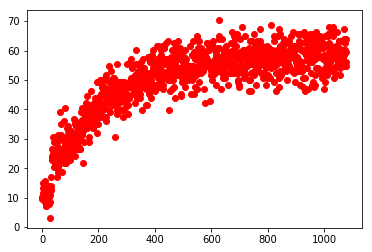

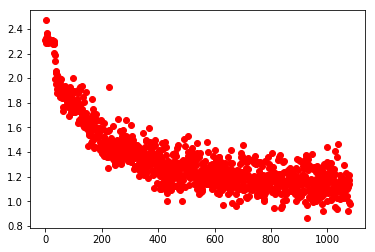

In [1]:
# 查看训练过程的信息
import  matplotlib.pyplot as plt

def parse(in_file,flag):
    num=-1
    ys=list()
    xs=list()
    losses=list()
    with open(in_file,"r") as reader:
        for aLine in reader:
            #print(aLine)

            res=[e for e in aLine.strip('\n').split(" ")]
            if res[0]=="Train" and flag=="Train":
                num=num+1
                ys.append(float(res[-1]))
                xs.append(int(num))
                losses.append(float(res[-3].split(',')[0]))
            if res[0]=="Validation" and flag=="Validation":
                num=num+1
                xs.append(int(num))
                tmp=[float(e) for e in res[-2].split('/')]
                ys.append(100*float(tmp[0]/tmp[1]))
                losses.append(float(res[-4].split(',')[0]))

    plt.figure(1)
    plt.plot(xs,ys,'ro')


    plt.figure(2)
    plt.plot(xs, losses, 'ro')
    plt.show()

def main():
    in_file="D://INFO.txt"
    # 显示训练阶段的正确率和Loss信息
    parse(in_file,"Train") # "Validation"
    # 显示验证阶段的正确率和Loss信息
    #parse(in_file,"Validation") # "Validation"


if __name__=="__main__":
    main()

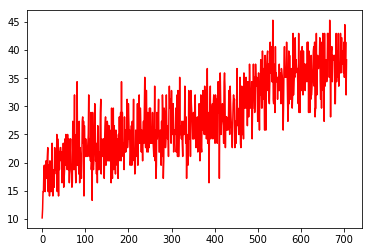

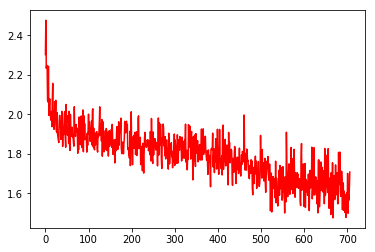

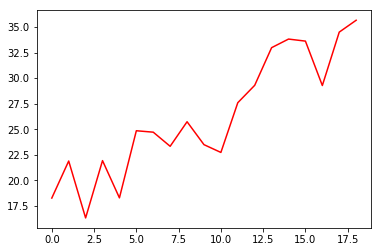

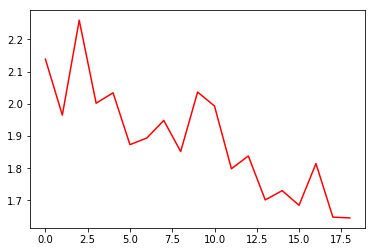

In [3]:
# 查看训练过程的信息
import  matplotlib.pyplot as plt

def parse(in_file,flag):
    num=-1
    ys=list()
    xs=list()
    losses=list()
    with open(in_file,"r") as reader:
        for aLine in reader:
            #print(aLine)

            res=[e for e in aLine.strip('\n').split(" ")]
            if res[0]=="Train" and flag=="Train":
                num=num+1
                ys.append(float(res[-1]))
                xs.append(int(num))
                losses.append(float(res[-3].split(',')[0]))
            if res[0]=="Validation" and flag=="Validation":
                num=num+1
                xs.append(int(num))
                tmp=[float(e) for e in res[-2].split('/')]
                ys.append(100*float(tmp[0]/tmp[1]))
                losses.append(float(res[-4].split(',')[0]))

    plt.figure(1)
    plt.plot(xs,ys,'r-')


    plt.figure(2)
    plt.plot(xs, losses, 'r-')
    plt.show()

def main():
    in_file="D://INFO.txt"
    # 显示训练阶段的正确率和Loss信息
    parse(in_file,"Train") # "Validation"
    # 显示验证阶段的正确率和Loss信息
    parse(in_file,"Validation") # "Validation"


if __name__=="__main__":
    main()